In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import cirq
from mitiq import zne, benchmarks
from mitiq.benchmarks import random_circuits
import math
import numpy as np
from functools import partial
import re 
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from mitiq import cdr, Observable, PauliString

from mitiq import pec
from mitiq.pec import NoisyOperation, OperationRepresentation
from mitiq.pec.representations.depolarizing import local_depolarizing_kraus
from mitiq.pec.channels import kraus_to_super
from mitiq.utils import _circuit_to_choi

In [3]:
import cirq
from qpe import generate_qpe_circuit
from cirq import ZPowGate
import numpy as np

from qpe import generate_qpe_circuit
phase = 5/16
U = ZPowGate(exponent=phase*2)
circuit, t, control, target = generate_qpe_circuit(U, 1, t=4)
# circuit, t, control, target = generate_qpe_circuit(U, 1, eps=0.3)
print(f't = {t}')
# print(dir(circuit))
print(f'depth = {len(circuit)}')

# Measure and print the results
circuit_with_measurement = circuit.copy()
circuit_with_measurement.append(cirq.measure(*control, key='result'))

s=cirq.Simulator()
print('Sampling the circuit:')
samples=s.run(circuit_with_measurement, repetitions=1000)
# Print a histogram of results
counts = samples.histogram(key='result')
print(counts)
most_freq_bitstring = sorted(counts, key=lambda k: counts[k], reverse=True)[0]
print(f'𝜙 = {most_freq_bitstring/2**t}')
exact = int(most_freq_bitstring)
print(exact)

myqubits = control + target
nqubits = len(myqubits)
#print(nqubits)

t = 4
depth = 17
Sampling the circuit:
Counter({5: 1000})
𝜙 = 0.3125
5


In [4]:
from typing import Tuple
from mitiq import Executor, Observable, PauliString, MeasurementResult
from mitiq.interface import mitiq_cirq
from mitiq.zne import execute_with_zne
from cirq import X, I

paulis = []
paulis.append(PauliString("I", coeff=0.5*(2**t-1)))
for p in range(t):    
    paulis.append(PauliString("Z", coeff=0.5*-2**(t-1-p), support=(p,)))
obs = Observable(*paulis)
print(obs)

def simulate(circuit: cirq.Circuit) -> np.ndarray:
    return mitiq_cirq.compute_density_matrix(circuit, noise_level=(0.0,))

def execute_noisy(circuit: cirq.Circuit) -> MeasurementResult:
    return mitiq_cirq.sample_bitstrings(circuit, noise_level=(0.01,))

#def execute_noisy2(circuit: cirq.Circuit, noise_level: (0.01,)) -> MeasurementResult:
#    return mitiq_cirq.sample_bitstrings(circuit, noise_level)

executor = Executor(mitiq_cirq.compute_density_matrix)
value = obs.expectation(circuit, execute=simulate).real
print(value)

value = obs.expectation(circuit, execute=execute_noisy).real
print(value)

zne_value = execute_with_zne(circuit, execute_noisy, obs).real
print(zne_value)
zne_value = max(min(zne_value, 2**t - 1), -2**t - 1)
print(zne_value)

(7.5+0j)*I + (-4+0j)*Z(0) + (-2+0j)*Z(1) + -Z(2) + (-0.5+0j)*Z(3)
4.9999987871790434
5.1544189453125
5.034301757812497
5.034301757812497


In [5]:
rng = np.random.default_rng()
def random_compile(mycircuit, nqubits, qreg, isTarget, type):
    def apply_cnot(mycircuit, operation = cirq.ops.gate_operation):
    
        myList =  [float(s) for s in re.findall(r'[-+]?\d*\.\d+|\d+', str(operation))] #r'\b\d+\b'
        phase = 0
        if len(myList) == 2:
            b0, b1 = int(myList[0]), int(myList[1])
        elif len(myList) == 3:
            phase, b0, b1 = myList[0], int(myList[1]), int(myList[2])
        
        if type == 0:
            mycircuit.append(operation)
        elif type == 1:
            mycircuit.append(cirq.X(qreg[b1]))
            mycircuit.append(operation)
            mycircuit.append(cirq.X(qreg[b1]))
        elif type == 2:
            mycircuit.append(cirq.Y(qreg[b1]))
            mycircuit.append(operation)
            mycircuit.append(cirq.Z(qreg[b0]))     
            mycircuit.append(cirq.Y(qreg[b1]))
        elif type == 3:
            mycircuit.append(cirq.Z(qreg[b1]))
            mycircuit.append(operation)
            mycircuit.append(cirq.Z(qreg[b0]))     
            mycircuit.append(cirq.Z(qreg[b1]))            
        elif type == 4:
            mycircuit.append(cirq.Y(qreg[b0]))
            mycircuit.append(operation)
            mycircuit.append(cirq.Y(qreg[b0]))     
            mycircuit.append(cirq.X(qreg[b1]))            
        elif type == 5:
            mycircuit.append(cirq.Y(qreg[b0]))
            mycircuit.append(cirq.X(qreg[b1]))
            mycircuit.append(operation)   
            mycircuit.append(cirq.Y(qreg[b0]))            
        elif type == 6:
            mycircuit.append(cirq.Y(qreg[b0]))
            mycircuit.append(cirq.Y(qreg[b1]))
            mycircuit.append(operation) 
            mycircuit.append(cirq.X(qreg[b0])) 
            mycircuit.append(cirq.Z(qreg[b1]))       
        elif type == 7:
            mycircuit.append(cirq.Y(qreg[b0]))
            mycircuit.append(cirq.Z(qreg[b1]))
            mycircuit.append(operation)  
            mycircuit.append(cirq.X(qreg[b0])) 
            mycircuit.append(cirq.Y(qreg[b1]))               
        elif type == 8:
            mycircuit.append(cirq.X(qreg[b0]))
            mycircuit.append(operation)  
            mycircuit.append(cirq.X(qreg[b0])) 
            mycircuit.append(cirq.X(qreg[b1]))               
        elif type == 9:
            mycircuit.append(cirq.X(qreg[b0]))
            mycircuit.append(cirq.X(qreg[b1]))
            mycircuit.append(operation)   
            mycircuit.append(cirq.X(qreg[b0]))              
        elif type == 10:
            mycircuit.append(cirq.X(qreg[b0]))
            mycircuit.append(cirq.Y(qreg[b1]))
            mycircuit.append(operation)
            mycircuit.append(cirq.Y(qreg[b0])) 
            mycircuit.append(cirq.Z(qreg[b1]))             
        elif type == 11:
            mycircuit.append(cirq.X(qreg[b0]))
            mycircuit.append(cirq.Z(qreg[b1]))
            mycircuit.append(operation)
            mycircuit.append(cirq.Y(qreg[b0])) 
            mycircuit.append(cirq.Y(qreg[b1]))             
        elif type == 12:
            mycircuit.append(cirq.Z(qreg[b0]))
            mycircuit.append(operation) 
            mycircuit.append(cirq.Z(qreg[b0]))           
        elif type == 13:
            mycircuit.append(cirq.Z(qreg[b0]))
            mycircuit.append(cirq.X(qreg[b1]))
            mycircuit.append(operation)   
            mycircuit.append(cirq.Z(qreg[b0])) 
            mycircuit.append(cirq.X(qreg[b1]))             
        elif type == 14:
            mycircuit.append(cirq.Z(qreg[b0]))
            mycircuit.append(cirq.Y(qreg[b1]))
            mycircuit.append(operation)
            mycircuit.append(cirq.Y(qreg[b1]))             
        elif type == 15:
            mycircuit.append(cirq.Z(qreg[b0]))
            mycircuit.append(cirq.Z(qreg[b1]))
            mycircuit.append(operation)
            mycircuit.append(cirq.Z(qreg[b1]))             
        return mycircuit   
    
    mycircuit2 = cirq.Circuit() 
    
    for moment in mycircuit:
        myTuple = moment.operations
        for i in myTuple:
            if(isTarget == True):
                    mycircuit2.append(i)
            else:
                #print(i)
                matchers = ['CXPowGate', 'CZ', 'CY', 'CX', 'CNOT']
                matching = bool([s for s in matchers if(s in str(i))])
                if matching == True:
                    #print("CNOT", print("i", type(i), i.gate)
                    mycircuit2 = apply_cnot(mycircuit2, i)
            
    #return cirq.ConvertToCzAndSingleGates().optimize_circuit(mycircuit2)        
    return mycircuit2 
    #return simplify(mycircuit2)
    
def fold(scale_factor, mycircuit):
    max_scale = math.ceil((scale_factor - 1)/2)*2 + 1
    p = 1 - (max_scale - scale_factor)/3
    mycircuit2 = cirq.Circuit() 

    for moment in mycircuit:
        myTuple = moment.operations
        for i in myTuple:
            matchers = ['CXPowGate', 'CZ', 'CY', 'CX', 'CNOT']
            matching = bool([s for s in matchers if(s in str(i))])
            if matching == True:
                #scale = rng.choice([max_scale,max_scale-2],p=[p,1-p])
                scale = scale_factor
                for _ in range(scale):
                    mycircuit2.append(i) 
            else:
                mycircuit2.append(i)
    return mycircuit2 


# def fold_and_compile(scale_factor, mycircuit, rand_compile, nqubits, qreg):
#     type = rng.integers(16)
#     mycircuit_fold = fold(scale_factor, mycircuit)
#     mycircuit_rand = random_compile(mycircuit, nqubits, qreg, type)
#     mycircuit_rand_fold = fold(scale_factor, mycircuit_rand)
#     #print("target_circuit\n", mycircuit, "\n")  
#     #print("target_circuit_fold\n", mycircuit_fold, "\n")
#     #print("estimation_circuit\n", mycircuit_rand, "\n")
#     #print("estimation_circuit_fold\n", mycircuit_rand_fold, "\n")
#     return mycircuit_rand, mycircuit_rand_fold


In [6]:
def add_rx_to_target_circuit(mycircuit, nqubits, qreg, randomness):
    mycircuit2 = cirq.Circuit() 
    
    #if randomness == True:
        #list0 = [np.random.uniform(0, 1*math.pi) for _ in range(nqubits)] #2*math.pi
    #else:
        #list0 = [math.pi/2 for _ in range(nqubits)] #math.pi/2
        
    list0 = [math.pi/6 for _ in range(nqubits)]
    
    for i in range(nqubits):
            mycircuit2.append(cirq.rx(list0[i]).on(qreg[i]))
            
    for moment in mycircuit:
        myTuple = moment.operations
        for i in myTuple:
                mycircuit2.append(i)
                
    for i in range(nqubits):
            mycircuit2.append(cirq.rx(-list0[i]).on(qreg[i]))
            
    return mycircuit2

In [7]:
from functools import partial
from cirq import depolarize, phase_flip, bit_flip, phase_damp, amplitude_damp
from mitiq.zne import RichardsonFactory
from tqdm import tqdm

num_to_average = 3
shots = 1024
noise_models = [depolarize, phase_flip, bit_flip, phase_damp, amplitude_damp]
noise_levels = [0.02, 0.04, 0.06, 0.08, 0.1]
scale_factors = [1.0, 3.0, 5.0, 7.0]
results = {}

#for nm in noise_models:
#    exp_vals = []
#    all_exp_values = {}
#    for noise_level in tqdm(noise_levels):
#        execute_with_noise = partial(mitiq_cirq.sample_bitstrings, noise_model=nm, noise_level=(noise_level,), shots=shots)
#        factory = RichardsonFactory(scale_factors=scale_factors)
#        exp_val = execute_with_zne(circuit, execute_with_noise, obs, factory=factory, num_to_average=num_to_average).real
#        all_exp_vals = factory.get_expectation_values()
#        all_exp_values[noise_level] = np.real(all_exp_vals)
#        exp_vals.append(exp_val)
#    
#    results[nm.__name__] = exp_vals, all_exp_values

In [8]:
#def simulate(circuit: cirq.Circuit) -> np.ndarray:
#    return mitiq_cirq.compute_density_matrix(circuit, noise_level=(0.0,))

#def execute_noisy(circuit: cirq.Circuit, noise_level=0.01) -> MeasurementResult:
#    return mitiq_cirq.sample_bitstrings(circuit, noise_level)  

#def execute(circuit: cirq.Circuit, noise_level: float = 0.001) -> float:
#    """Returns Tr[ρ |0⟩⟨0|] where ρ is the state prepared by the circuit with depolarizing noise."""
#    noisy_circuit = circuit.with_noise(cirq.depolarize(p=noise_level))
#    return cirq.DensityMatrixSimulator().simulate(noisy_circuit).final_density_matrix[0, 0].real

def execute(circuit: cirq.Circuit, noise_model: cirq.NoiseModel, noise_level: float = 0.001) -> float:
    """Returns Tr[ρ |0⟩⟨0|] where ρ is the state prepared by the circuit with depolarizing noise."""
    #noisy_circuit = circuit.with_noise(noise_model = noise_model, p=my_noise_level)

    nm = cirq.NoiseModel.from_noise_model_like(noise_model(noise_level))
    
    noisy_circuit = circuit.with_noise(nm)
    return cirq.DensityMatrixSimulator().simulate(noisy_circuit).final_density_matrix[0, 0].real

In [46]:
from mitiq import pec
from mitiq.pec import *
from mitiq.pec.pec import *
from mitiq.pec.representations import *

num_to_average = 1#3
shots = 1024*8
scale_factors = [1.0, 3.0, 5.0, 7.0]
factory = RichardsonFactory(scale_factors = scale_factors)

def doSimulation (nTrials, noise_level, doZNE, doCDR, doPEC, nm, nqubits, original_circuit):#, target_circuit, estimation_circuit):
    
  

    error1, error2, error3, error4, error2z, error4z, error2p, error4p = 0, 0, 0, 0, 0, 0, 0, 0
    for i in range(nTrials):
        
        
        
        target_circuit = add_rx_to_target_circuit(original_circuit, nqubits, myqubits, False)# circuit
        #target_circuit = add_rx_to_target_circuit(random_compile(original_circuit, nqubits, myqubits, True, type = rng.integers(16)), nqubits, myqubits, False)
        estimation_circuit = add_rx_to_target_circuit(random_compile(original_circuit, nqubits, myqubits, False, type = rng.integers(16)), nqubits, myqubits, True)        
        
        cirq.ConvertToCzAndSingleGates().optimize_circuit(target_circuit)
        cirq.ConvertToCzAndSingleGates().optimize_circuit(estimation_circuit)    

        cdr_value, zne_value, pec_value, zne_value_cor, zne_value_org, cdr_value_cor, cdr_value_org, pec_value_cor, pec_value_org = 0, 0, 0, 0, 0, 0, 0, 0, 0

        execute_with_noise = partial(mitiq_cirq.sample_bitstrings, noise_model=nm, noise_level=(noise_level,), shots=shots)      

        true_value = obs.expectation(target_circuit, execute=simulate).real
        true_value_org = obs.expectation(original_circuit, execute=simulate).real
        noisy_value =  obs.expectation(target_circuit, execute=execute_with_noise).real
        noisy_value_org =  obs.expectation(original_circuit, execute=execute_with_noise).real
        noisy_value_est = obs.expectation(estimation_circuit, execute=execute_with_noise).real # Noisy version with the estimation circuit. 
        noisy_value_cor = noisy_value / noisy_value_est * true_value  # Corrected 
        

        print("true_value, true_value_org, noisy_value, noisy_value_est, noisy_value_cor, noisy_value_org", true_value, true_value_org, noisy_value, noisy_value_est, noisy_value_cor, noisy_value_org)
         
        if(doZNE): #ZNE
            zne_value     = execute_with_zne(target_circuit,     execute_with_noise, obs, factory=factory, num_to_average=num_to_average).real
            zne_value_est = execute_with_zne(estimation_circuit, execute_with_noise, obs, factory=factory, num_to_average=num_to_average).real
            zne_value_cor = zne_value / zne_value_est * true_value # Corrected
            _1_p = zne_value_est / noisy_value_est
            #zne_value_cor = zne_value / _1_p
            zne_value_org = execute_with_zne(original_circuit,     execute_with_noise, obs, factory=factory, num_to_average=num_to_average).real
            print("zne_value, zne_value_est, zne_value_cor, zne_value_org", zne_value, zne_value_est, zne_value_cor, zne_value_org)
          
        if(doCDR): #CDR
            cdr_value     = cdr.execute_with_cdr(target_circuit,     execute_with_noise, observable=obs,simulator=simulate,).real # Noisy quantum computer + Mitiq.
            cdr_value_est = cdr.execute_with_cdr(estimation_circuit, execute_with_noise, observable=obs,simulator=simulate,).real # CDR version with the estimation circuit.
            cdr_value_cor = cdr_value / cdr_value_est * true_value # Corrected true_value *
            _1_p = cdr_value_est / noisy_value_est
            #cdr_value_cor = cdr_value / _1_p
            cdr_value_org = cdr.execute_with_cdr(original_circuit,     execute_with_noise, observable=obs,simulator=simulate,).real
            print("cdr_value, cdr_value_est, cdr_value_cor, cdr_value_org", cdr_value, cdr_value_est, cdr_value_cor, cdr_value_org)

        if(doPEC): #PEC
            #representations0 = representations.represent_operations_in_circuit_with_local_depolarizing_noise(original_circuit, noise_level=noise_level,)#.001
            #representations1 = representations.represent_operations_in_circuit_with_local_depolarizing_noise(target_circuit, noise_level=noise_level,)#.001
            #representations2 = representations.represent_operations_in_circuit_with_local_depolarizing_noise(estimation_circuit, noise_level=noise_level,)#0.001    
            representations0 =  represent_operations_in_circuit_with_local_depolarizing_noise(original_circuit, noise_level=noise_level)
            representations1 =  represent_operations_in_circuit_with_local_depolarizing_noise(target_circuit, noise_level=noise_level)
            representations2 =  represent_operations_in_circuit_with_local_depolarizing_noise(estimation_circuit, noise_level=noise_level)

            num_samples = 50
            #pec_value, pec_data = pec.execute_with_pec(circuit=target_circuit, executor=execute_with_noise,     ##########doubt############
            #    representations=representations1, num_samples = 50, full_output=True, random_state = np.random.RandomState(7),)  # Noisy quantum computer + Mitiq.           
            #pec_value_est, pec_data_est = pec.execute_with_pec(circuit=estimation_circuit, executor=execute_with_noise,     ##########doubt############
            #    representations=representations2, num_samples = 50, full_output=True, random_state = np.random.RandomState(7),) # CDR version with the estimation circuit.
            pec_value, pec_data =         pec.execute_with_pec(circuit    =target_circuit, executor=partial(execute, noise_model=nm, noise_level=my_noise_level),    #
                representations=representations1, num_samples = num_samples, full_output=True, random_state = np.random.RandomState(7), precision=0.1,)  # Noisy quantum computer + Mitiq.        
            pec_value_est, pec_data_est = pec.execute_with_pec(circuit=estimation_circuit, executor=partial(execute, noise_model=nm, noise_level=my_noise_level),     ##########doubt############
                representations=representations2, num_samples = num_samples, full_output=True, random_state = np.random.RandomState(7), precision=0.1)                    
            pec_value_cor = pec_value / pec_value_est * nqubits # Corrected
            pec_value_org, pec_data_org = pec.execute_with_pec(circuit=original_circuit, executor=partial(execute, noise_model=nm, noise_level=my_noise_level),     ##########doubt############
                representations=representations1, num_samples = num_samples, full_output=True, random_state = np.random.RandomState(7),precision=0.1)  # Noisy quantum computer + Mitiq.        
        
            print("pec_value, pec_value_est, pec_value_cor, pec_value_org", pec_value, pec_value_est, pec_value_cor, pec_value_org)


        error1 = error1 + 1/nTrials* abs((true_value_org - noisy_value_org) / true_value_org**0) #w/o unmitigated
        error2 = error2 + 1/nTrials* abs((true_value_org - cdr_value_org) / true_value_org**0) #with Mitiq CDR, w/o RC
        error3 = error3 + 1/nTrials* abs((true_value - noisy_value_cor) / true_value**0) #w/o Mitiq, with RC
        error4 = error4 + 1/nTrials* abs((true_value - cdr_value_cor) / true_value**0) #with both Mitiq CDR & RC  
        error2z = error2z + 1/nTrials* abs((true_value_org - zne_value_org) / true_value_org**0) #with Mitiq ZNE, w/o RC
        error4z = error4z + 1/nTrials* abs((true_value - zne_value_cor) / true_value**0) #with both Mitiq ZNE & RC 
        error2p = error2p + 1/nTrials* abs((true_value_org - pec_value_org) / true_value_org**0) #with Mitiq PEC, w/o RC
        error4p = error4p + 1/nTrials* abs((true_value - pec_value_cor) / true_value**0) #with both Mitiq PEC & RC 
        
    return error1, error2, error3, error4, error2z, error4z, error2p, error4p




In [47]:
nTrials = 1

#my_noise_level_array = [0 , 0.005]+[ 0.01 *i for i in range(1,9,1)]# [0.01 *i for i in range(0,9,1)] 
#my_noise_level_array = [0.01 *i for i in range(1,7,2)]
#my_noise_level_array = [0.01 *i for i in range(0,9,3)]
my_noise_level_array = [0 , 0.005]+[0.01 *i for i in range(1,8,2)]

doZNE, doCDR, doPEC = False, False, True
#noise_models = [depolarize, phase_flip, bit_flip, phase_damp, amplitude_damp]
noise_models = [depolarize]


original_circuit = circuit
#cirq.ConvertToCzAndSingleGates().optimize_circuit(original_circuit)

#cirq.ConvertToCzAndSingleGates().optimize_circuit(original_circuit)
#target_circuit = add_rx_to_target_circuit(original_circuit, nqubits, myqubits, False)# circuit
##target_circuit = add_rx_to_target_circuit(random_compile(circuit2, nqubits, myqubits, True, type = rng.integers(16)), nqubits, myqubits, True)
#target_circuit = add_rx_to_target_circuit(random_compile(original_circuit, nqubits, myqubits, True, type = rng.integers(16)), nqubits, myqubits, False)
#estimation_circuit = add_rx_to_target_circuit(random_compile(original_circuit, nqubits, myqubits, False, type = rng.integers(16)), nqubits, myqubits, True)

all_error_values = {}
for nm in noise_models:
    errors_nm = []
    error1_array, error2_array, error3_array, error4_array, error2z_array, error4z_array, error2p_array, error4p_array = [], [], [], [], [], [], [], []
    for my_noise_level in my_noise_level_array:    
        print("\n", nm.__name__, my_noise_level)
        error1, error2, error3, error4, error2z, error4z, error2p, error4p = doSimulation (nTrials, my_noise_level, doZNE, doCDR, doPEC, nm, nqubits, original_circuit)#, target_circuit, estimation_circuit)
        error1_array.append(error1)
        error2_array.append(error2)
        error3_array.append(error3)
        error4_array.append(error4)
        error2z_array.append(error2z)
        error4z_array.append(error4z)    
        error2p_array.append(error2p)
        error4p_array.append(error4p) 
    errors_nm.append(error1_array)
    errors_nm.append(error2_array)
    errors_nm.append(error3_array)
    errors_nm.append(error4_array)
    errors_nm.append(error2z_array)
    errors_nm.append(error4z_array)
    errors_nm.append(error2p_array)
    errors_nm.append(error4p_array)
    
    all_error_values[nm.__name__] = errors_nm




 depolarize 0
true_value, true_value_org, noisy_value, noisy_value_est, noisy_value_cor, noisy_value_org 4.8957525277510285 4.99999546750191 4.953125 0.3880615234375 62.48822100221004 5.0
pec_value, pec_value_est, pec_value_cor, pec_value_org 0.04863043129444122 0.9495115280151367 0.25608131054553124 0.0

 depolarize 0.005
true_value, true_value_org, noisy_value, noisy_value_est, noisy_value_cor, noisy_value_org 4.8957525277510285 4.99999546750191 6.163818359375 5.507080078125 5.479587891480703 6.2530517578125
pec_value, pec_value_est, pec_value_cor, pec_value_org 0.07739364739353913 0.012604470715651028 30.7008715952821 0.01360392374756525

 depolarize 0.01
true_value, true_value_org, noisy_value, noisy_value_est, noisy_value_cor, noisy_value_org 4.8957525277510285 4.99999546750191 6.719970703125 4.8223876953125 6.822204193208306 6.87451171875
pec_value, pec_value_est, pec_value_cor, pec_value_org 0.027996645179604276 0.45344452934851387 0.3087108054851653 0.0014301372001462847

 dep

In [ ]:
#print(print(f'depth (original) = {len(original_circuit)}'))
#print(print(f'depth (target) = {len(target_circuit)}'))
#print(print(f'depth (estimation)= {len(estimation_circuit)}'))
#print(target_circuit, "\n\n")
#print(estimation_circuit)

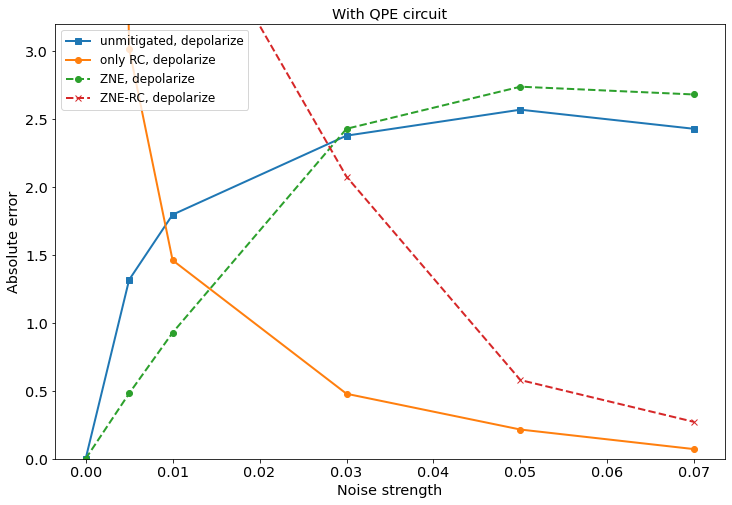

In [18]:
import matplotlib.pyplot as plt

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'lines.linewidth':2}
plt.rcParams.update(params)

plt.figure(figsize=(12, 8))

#range=-3 [:range]



my_noise_models = noise_models #noise_models = [depolarize, phase_flip, bit_flip, phase_damp, amplitude_damp]
#my_noise_models = [phase_damp]

for noise_model_index in range(len(my_noise_models)):

    noise_model_name = my_noise_models[noise_model_index].__name__
    error1_array, error2_array, error3_array, error4_array, error2z_array, error4z_array, error2p_array, error4p_array = all_error_values[noise_model_name]

    plt.plot(my_noise_level_array, error1_array, "-s", label="unmitigated, " + noise_model_name)
    plt.plot(my_noise_level_array, error3_array, "-o", label="only RC, " + noise_model_name)
    if(doZNE): #ZNE
        plt.plot(my_noise_level_array, error2z_array, "--o", label="ZNE, " + noise_model_name)
        plt.plot(my_noise_level_array, error4z_array, "--x", label="ZNE-RC, " + noise_model_name)
    if(doCDR): #CDR    
        plt.plot(my_noise_level_array, error2_array, "--o", label="CDR, " + noise_model_name)
        plt.plot(my_noise_level_array, error4_array, "--o", label="CDR-C, " + noise_model_name)
    if(doPEC): #PEC
        plt.plot(my_noise_level_array, error2p_array, "--o", label="PEC, " + noise_model_name)
        plt.plot(my_noise_level_array, error4p_array, "--o", label="PEC-RC, " + noise_model_name)      

    
#plt.plot(my_noise_level_array, error1_array, "-s", label="unmitigated") 
#plt.plot(my_noise_level_array, error3_array, "--o", label="RC")    
#plt.plot(my_noise_level_array, error2z_array, "--o", label="ZNE")  
#plt.plot(my_noise_level_array, error4z_array, "--x", label="ZNE-RC")   

#def mult(list, exact):
    #return [value*exact for value in list] #mult(error1_array, exact)

plt.xlabel("Noise strength")
plt.ylabel("Absolute error")
plt.title("With QPE circuit")
#plt.title("Noise model: " + noise_models[noise_model_index].__name__)
#plt.title("Noise model: " + noise_models[noise_model_index1].__name__ + " vs " + noise_models[noise_model_index2].__name__)

ax = plt.gca()
ax.set_ylim([0, 3.2])

plt.legend()
plt.legend(loc=2, prop={'size': 12})
#plt.savefig('zne_rc2.png', dpi=300, facecolor='white')
#plt.savefig('H:\QuantumComm\QISKIT\QCourse511\Proje\MITIQ\mitiq-master\docs\jupyter_execute\examples\zne_rc_qpe_dep.png', dpi=300, facecolor='white')
plt.show();